Part II:
- loads the feature files for each snapshot from the features_csv folder
- perform a clustering algorithm on each snapshot and plot the results

In [1]:
import pandas as pd
import os

# Directory where the CSV files are stored
input_directory = "features_csv"

# Get a list of all CSV files in the directory
csv_files = [f for f in os.listdir(input_directory) if f.endswith(".csv")]

# Sort the CSV files based on the numeric part of the filename: 100ps, 200ps, .............., 2300ps
csv_files.sort(key=lambda x: int(os.path.splitext(x)[0]))

# Initialize an empty dictionary to store the DataFrames
df_dict = {}

# Loop through the sorted CSV files and load them into DataFrames
for csv_file in csv_files:
    # Extract the numeric part of the filename (e.g., "100" from "100.csv")
    numeric_part = os.path.splitext(csv_file)[0]
#     numeric_part = filename_without_extension
    
    # Load the CSV file into a DataFrame and use the numeric part as the key
    df_dict[numeric_part] = pd.read_csv(os.path.join(input_directory, csv_file))



In [2]:
df_dict

{'100':           ID         x          y         z        Q6  Nc_6  dist_from_c  \
 0      38987 -19.11470   8.822960  -3.80674  0.337304     3    21.394103   
 1      38988 -18.79600  11.248300   3.19368  0.299202    12    22.136248   
 2      38989 -20.37750  -2.252940  -1.52985  0.267150    12    20.558664   
 3      38990 -20.84970  -3.851380   2.73896  0.328299    19    21.378611   
 4      38991 -20.88110  -0.252972   1.07427  0.272038    13    20.910246   
 ...      ...       ...        ...       ...       ...   ...          ...   
 60715  99702   1.58532  27.319200  34.11790  0.340028     0    43.736518   
 60716  99703  54.20630  39.444900  56.04990  0.290948     1    87.383147   
 60717  99704  -2.54915 -37.136700 -50.65150  0.229228     0    62.858628   
 60718  99705  50.36620  40.244600 -38.87350  0.220871     3    75.283006   
 60719  99706 -45.99080 -49.785600   7.40352  0.228634     3    68.180435   
 
            disp      d_5NN  N_N  
 0      0.872709   3.439096    8

- df_dict is a dictionary with keys in increasing order of snapshot time from 100-2300
- To confirm the order you may run
   - df_dict.keys()
   
__Let us work out the clustering algorithm now__

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import pyprind
import numpy as np 
prog_bar = pyprind.ProgBar(len(df_dict.keys()))

n_atoms_per_cluster, avg_disp_per_cluster, avg_Nc_per_cluster = [], [], []
mean_Q6_snap, mean_Nc_snap, mean_disp_snap = [],[],[]
inertia, cc_I, cc_II = [],[],[]
ct_Nc_gt_10 = []

for identifier, df in df_dict.items():
    X = df
    rx,ry,rz = X['x'], X['y'], X['z']
    X_mat = X[['Q6','Nc_6','disp','N_N']].values
    
    ct_Nc_gt_10.append(len(X_mat[X_mat[:,3]>10]))
    mean_Q6_snap.append(np.mean(X_mat[:,0]))
    mean_Nc_snap.append(np.mean(X_mat[:,1]))
    mean_disp_snap.append(np.mean(X_mat[:,2]))
    
    sc = StandardScaler()
    sc.fit(X_mat)
    X_std = sc.transform(X_mat)
    
    km = KMeans(n_clusters=2,  init='k-means++', n_init=100, max_iter=100000, tol=1e-10, random_state=0)
    y_km = km.fit_predict(X_std)    

    cc_I.append(km.cluster_centers_[0,:])
    cc_II.append(km.cluster_centers_[1,:])  
    
    n_c = 2
    # Calculate the mean value of the 2nd column for each cluster
    avg_2nd_col = [np.mean(X_mat[km.labels_ == i, 1]) for i in range(n_c)]

# Determine the cluster with the larger mean value of the 2nd column as label 1, and the other as label 0
    larger_avg_c = np.argmax(avg_2nd_col)
    c_labels = [1 if i == larger_avg_c else 0 for i in range(n_c)]

# Map cluster labels to the original KMeans labels
    final_labels = [c_labels[km_label] for km_label in km.labels_]
# Add the final cluster labels to the DataFrame
    df['Cluster_Labels'] = final_labels
    n_atoms_per_cluster.append([final_labels.count(1), final_labels.count(0)])
#     print(sorted_chunks[ind][sorted_chunks[ind]['Cluster_Labels'] == 0]['disp'].mean())
#     print(sorted_chunks[ind][sorted_chunks[ind]['Cluster_Labels'] == 1]['disp'].mean())

# Add average displacment per cluster
    filtered_df0 = df[df['Cluster_Labels'] == 0]
    filtered_df1 = df[df['Cluster_Labels'] == 1]
    
    avg_disp_per_cluster.append([filtered_df1['disp'].mean(), filtered_df0['disp'].mean()])
    avg_Nc_per_cluster.append([filtered_df1['Nc_6'].mean(), filtered_df0['Nc_6'].mean()])

    prog_bar.update()    


0% [#######################] 100% | ETA: 00:00:00
Total time elapsed: 00:04:04


Create a 2D plot of the various feature pairs

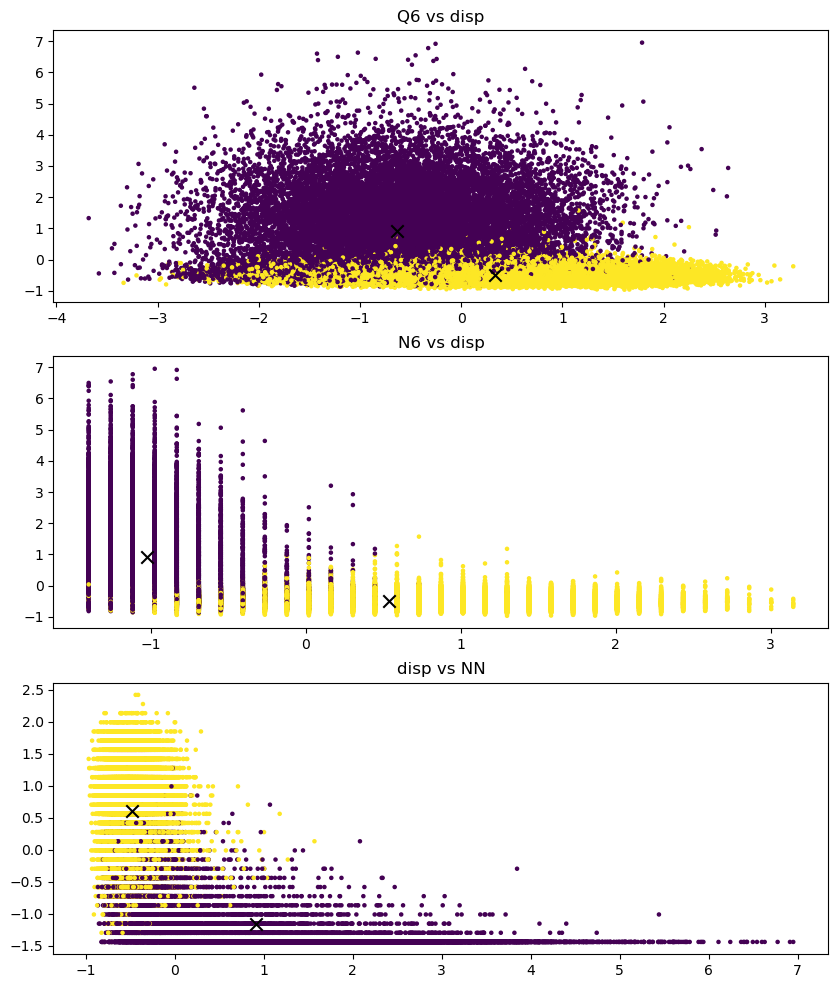

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,12))
plt.subplot(311)
plt.scatter(X_std[:, 0], X_std[:, 2],s = 5,\
            c=km.labels_, cmap='viridis')
plt.scatter(km.cluster_centers_[:, 0],\
            km.cluster_centers_[:, 2], s = 80,\
            marker= 'x', color = 'k')
plt.title('Q6 vs disp')

plt.subplot(312)
plt.scatter(X_std[:, 1], X_std[:, 2],s = 5,\
            c=km.labels_, cmap='viridis')
plt.scatter(km.cluster_centers_[:, 1],\
            km.cluster_centers_[:, 2], s = 80,\
            marker= 'x', color = 'k')
plt.title('N6 vs disp')

plt.subplot(313)
plt.scatter(X_std[:, 2], X_std[:, 3],s = 5,\
            c=km.labels_, cmap='viridis')
plt.scatter(km.cluster_centers_[:, 2],\
            km.cluster_centers_[:, 3], s = 80,\
            marker= 'x', color = 'k')
plt.title('disp vs NN')
plt.show()

In [4]:
avg_Nc_per_cluster

[[13.235074626865671, 2.1692404006677797],
 [13.578592814371257, 2.1864332063760754],
 [13.074646074646076, 2.1599950051732133],
 [13.45260492040521, 2.19691259602841],
 [13.701037037037038, 2.186770428015564],
 [13.484497133923918, 2.192670236030465],
 [13.308482090771205, 2.1890927918080885],
 [13.638493385842674, 2.2170336698348976],
 [13.441108952851845, 2.195266631574685],
 [13.357303894892327, 2.2025409031071734],
 [13.874432785025524, 2.219002059378754],
 [13.375944584382871, 2.213135593220339],
 [13.308358991903296, 2.239405307767125],
 [13.325271879854997, 2.248104322627385],
 [13.476732161323682, 2.3058865284185974],
 [13.507933863645828, 2.325614971805279],
 [13.779981655583581, 2.3395265381721364],
 [13.434174062510962, 2.33610654083755],
 [13.507635682691376, 2.3785255656032542],
 [13.51205574061058, 2.4168660927956567],
 [13.79663274850486, 2.4899170564880695],
 [13.667039612136712, 2.55515292696605],
 [13.645441752939995, 2.629277384821258]]

In [5]:
n_atoms_per_cluster

[[3216, 57504],
 [4008, 56712],
 [4662, 56058],
 [5528, 55192],
 [6750, 53970],
 [7676, 53044],
 [8571, 52149],
 [9903, 50817],
 [11326, 49394],
 [12863, 47857],
 [14104, 46616],
 [15880, 44840],
 [17538, 43182],
 [19310, 41410],
 [21274, 39446],
 [24011, 36709],
 [26166, 34554],
 [28507, 32213],
 [30973, 29747],
 [32723, 27997],
 [35281, 25439],
 [37539, 23181],
 [39796, 20924]]

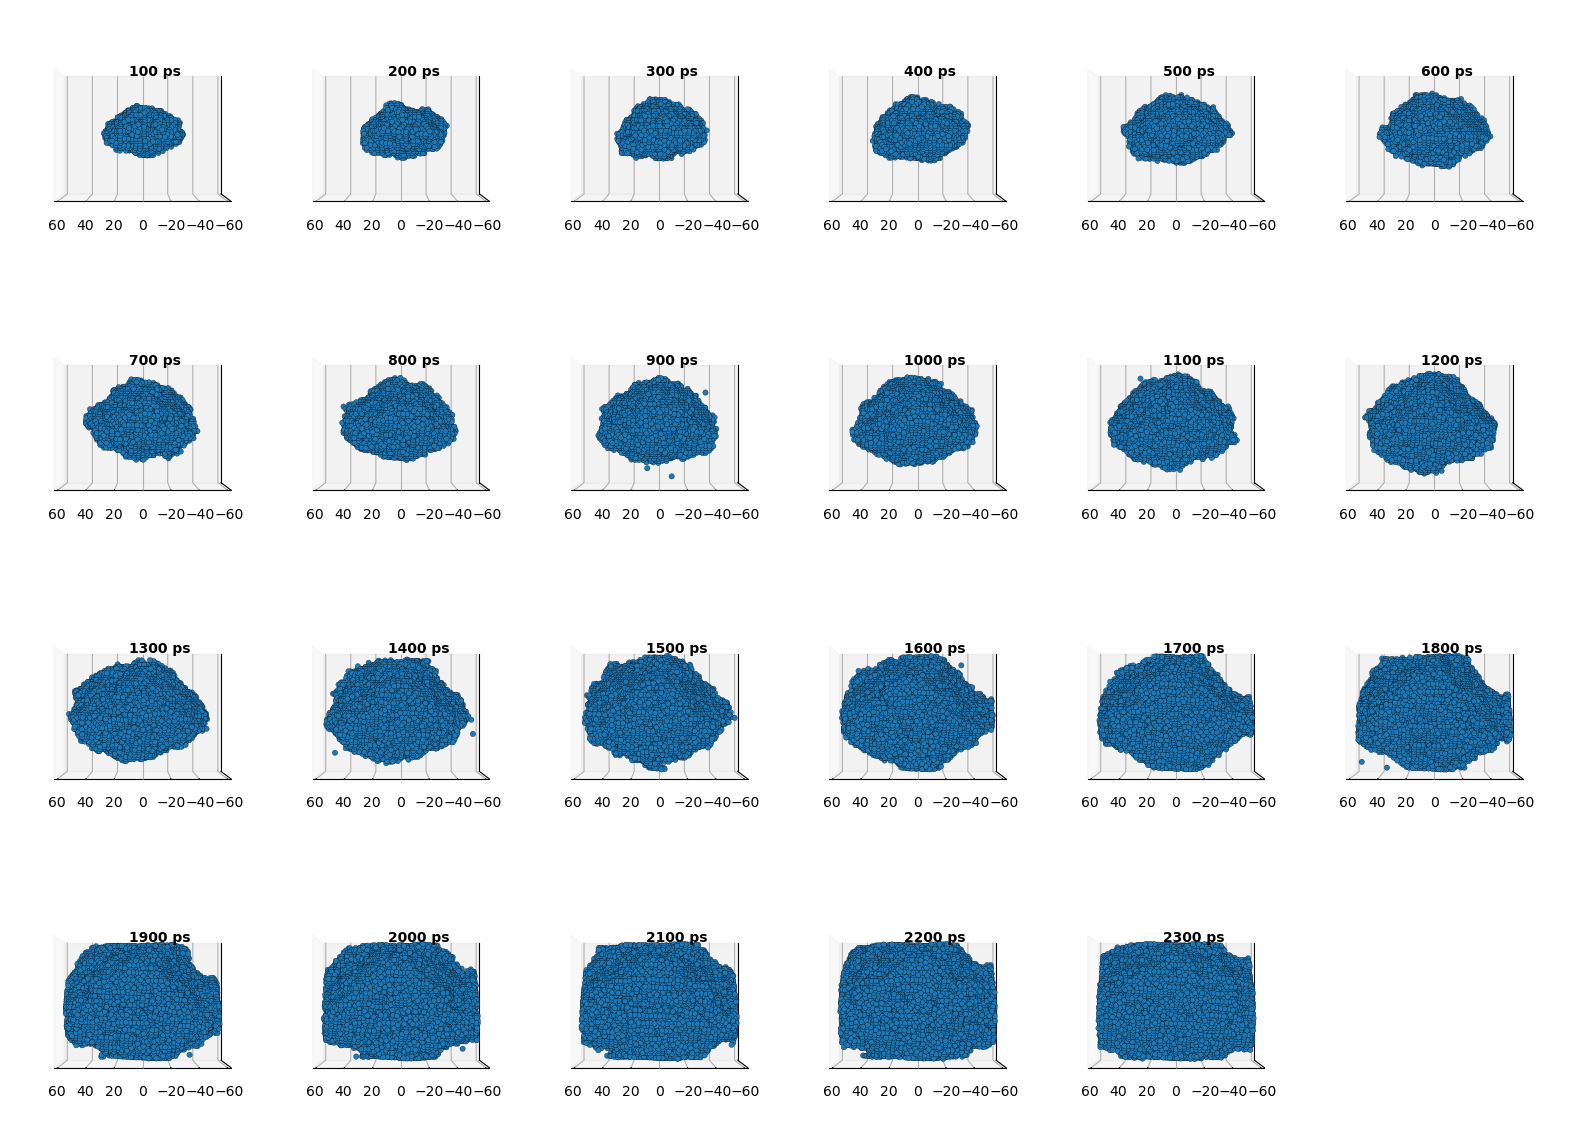

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D  # Import Axes3D for 3D plots


fig = plt.figure(figsize=(20,15))
gs = gridspec.GridSpec(4, 6, wspace=0.0005, hspace=0.0005)

# for ind in range(len(df_dict.keys())):
ind = 0 
for identifier, df in df_dict.items():
    X = df
    rx,ry,rz = np.asarray(X['x']), np.asarray(X['y']), np.asarray(X['z'])
    indices = []
    for ct_ in range(len(X)):
        if X['Cluster_Labels'].iloc[ct_] == 1:
            indices.append(ct_)
    selected_rows = X.iloc[indices]
    
    
#     if ind== 19:
#         selected_rows[['x','y','z']].to_csv('pred_crystals_2000ps.xyz', sep='\t', header=None, index=None)

#         print(selected_rows[['Q6','Nc_6','disp','N_N']])

    x_slice, y_slice, z_slice = [rx[i] for i in indices], [ry[i] for i in indices],[rz[i] for i in indices]
    ax = fig.add_subplot(gs[ind//6, ind%6], projection='3d')
    ax.scatter(x_slice, y_slice, z_slice, s=15.0, linewidth=0.2, alpha=1.0,edgecolor='k');
    
    ax.view_init(elev=0, azim=90, roll=0)
    ax.text(10.0, 0.0, 60.0, f'{(ind+1)*100} ps', color='k', fontsize=10, fontweight='bold')
    ax.set_xlim(-60,60)
    ax.set_ylim(-60,60)
    ax.set_zlim(-60,60)
#     ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ind += 1
plt.savefig("crystal_Ox_cluster.png",dpi=400)
# plt.tight_layout()
plt.show()


In [7]:
NAT = len(df_dict['100'])

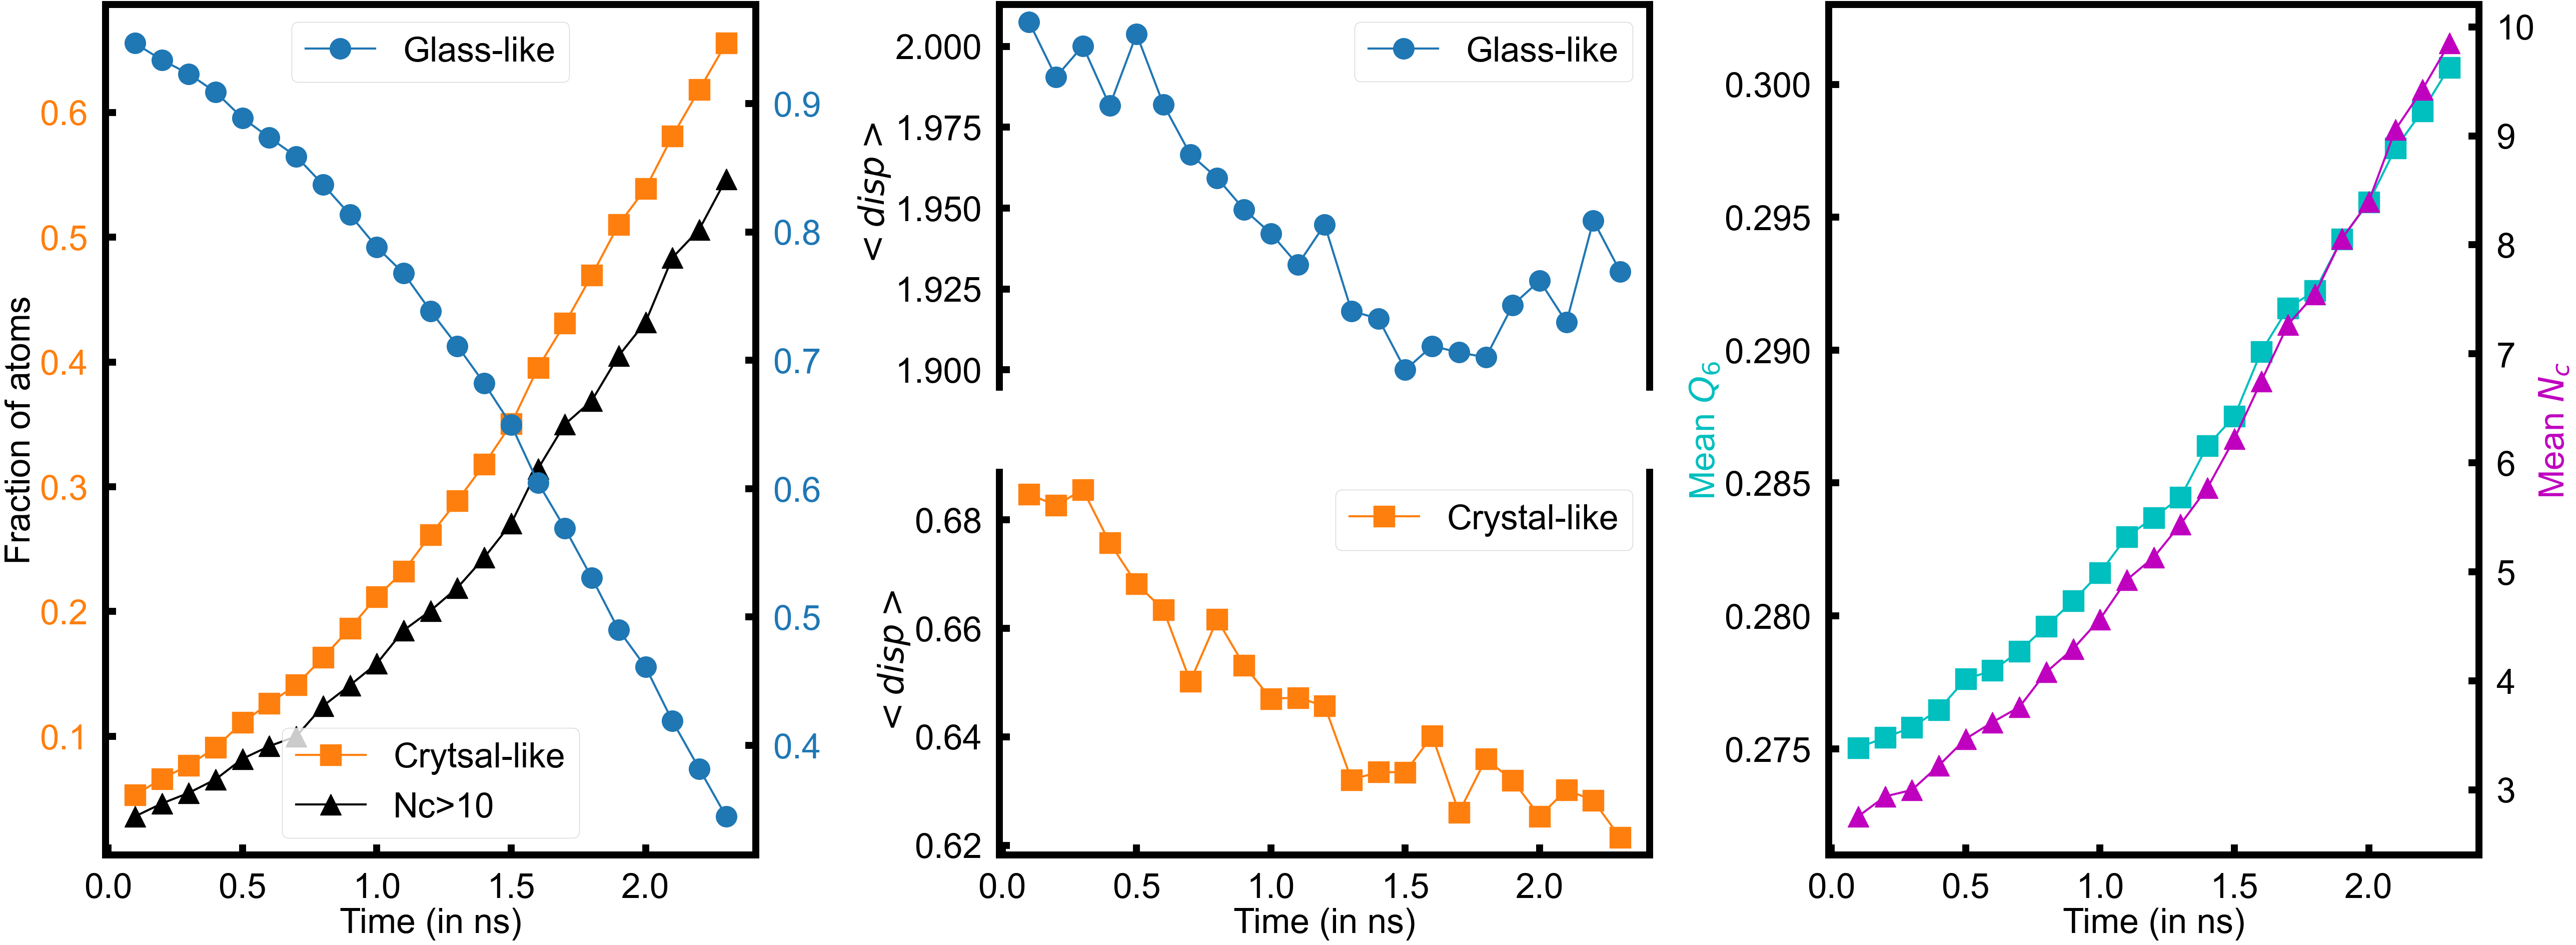

In [27]:
n_atoms_per_cluster = np.asarray(n_atoms_per_cluster)
avg_disp_per_cluster = np.asarray(avg_disp_per_cluster)

import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['font.size'] = 50
plt.rcParams['axes.labelsize'] = 50
plt.rcParams['axes.labelweight'] = 'normal'
plt.rcParams['axes.titlesize'] = 75
plt.rcParams['axes.titleweight']='normal'
plt.rcParams['xtick.labelsize'] =50
plt.rcParams['ytick.labelsize'] =50
plt.rcParams['lines.linewidth']=3.0
plt.rcParams['figure.figsize'] = 65,20
plt.rcParams['lines.markersize']=30.0
plt.rcParams['axes.linewidth'] =10

plt.rcParams['xtick.major.size']=15
plt.rcParams['xtick.direction']= 'in'
plt.rcParams['xtick.major.width']=10.0

plt.rcParams['ytick.major.size']=15
plt.rcParams['ytick.direction']= 'in'
plt.rcParams['ytick.major.width']=10.0

plt.rcParams['xtick.major.pad']='25'
plt.rcParams['ytick.major.pad']='25'


left,bottom,width,height = 0.04,0.04,0.20,0.85
rect_one = [left, bottom, width, height]
rect_two= [left+width+0.075, bottom, width, 0.45*height]            
rect_two_top= [left+width+0.075, bottom+0.55*height, width, 0.45*height]            
rect_three= [left+2*width+0.13, bottom, width, height]            

one_plot = plt.axes(rect_one)
two_plot = plt.axes(rect_two)
two_plot_top = plt.axes(rect_two_top)
three_plot = plt.axes(rect_three)


time_vals = np.linspace(0.1, 2.3, 23)

one_plot.plot(time_vals,[i/NAT for i in n_atoms_per_cluster[:,0]], marker='s', label='Crytsal-like', color='#ff7f0e')
one_plot.plot(time_vals,[i/NAT for i in ct_Nc_gt_10], marker='^', label='Nc>10', color='k')
one_twin = one_plot.twinx()
one_twin.plot(time_vals,[i/NAT for i in n_atoms_per_cluster[:,1]], marker='o', label='Glass-like', color='#1f77b4')
# one_plot.plot(time_vals,ct_Nc_gt_10, marker='^',lw=0.0, color='red')
one_plot.set_xlabel('Time (in ns)')
one_plot.set_ylabel('Fraction of atoms')

two_plot.plot(time_vals,avg_disp_per_cluster[:,0], marker='s', label='Crystal-like', color='#ff7f0e')
two_plot_top.plot(time_vals,avg_disp_per_cluster[:,1], marker='o', label='Glass-like', color='#1f77b4')
two_plot.set_xlabel('Time (in ns)')
two_plot.set_ylabel('$<disp>$')
two_plot_top.set_ylabel('$<disp>$')
two_plot.spines['top'].set_visible(False)
two_plot_top.spines['bottom'].set_visible(False)
two_plot_top.set_xticklabels([])
two_plot_top.set_xticks([])

three_plot.plot(time_vals,mean_Q6_snap, marker='s', color='c')
three_twin = three_plot.twinx()
three_twin.plot(time_vals,mean_Nc_snap, marker='^', color='m')

three_plot.set_xlabel('Time (in ns)')
three_plot.set_ylabel('Mean $Q_6$', color='c')
three_twin.set_ylabel('Mean $N_c$', color='m')
three_plot.set_ylim(0.271,0.303)

one_plot.legend(loc='lower center')
one_twin.legend(loc='upper center')
one_twin.yaxis.set_tick_params(labelcolor='#1f77b4')  # Set the color to red
one_plot.yaxis.set_tick_params(labelcolor='#ff7f0e')  # Set the color to red
# one_plot.yticklabels(color='#1f77b4')
two_plot.legend()
two_plot_top.legend()
plt.savefig("f_time_evol.pdf",dpi=500, bbox_inches="tight")
# plt.savefig("f_time_evol.png",dpi=500, bbox_inches="tight")
plt.show()